In [1]:
from tensorflow.keras import layers, Model
from matplotlib import pyplot as plt
import nibabel as nib
import numpy as np
import glob

In [ ]:
class AutoEncoder3DOld: # Works but it uses 2d convolutional layers >:(
    def __init__(self, input_shape):
        # Encoder
        encoder_input = layers.Input(shape=input_shape)
        x = layers.Conv2D(32, (3, 3), activation="relu", padding="same")(encoder_input)
        x = layers.MaxPooling2D((2, 2), padding="same")(x)
        x = layers.Dropout(0.1)(x)
        encoded = layers.Conv2D(8, (3, 3), activation="relu", padding="same")(x)
        encoded = layers.MaxPooling2D((2, 2), padding="same")(encoded)

        self.encoder = Model(encoder_input, encoded, name="encoder")

        # Decoder
        decoder_input = layers.Input(shape=(64, 64, 8))  # Shape of encoded latent space
        x = layers.Conv2D(8, (3, 3), activation="relu", padding="same")(decoder_input)
        x = layers.UpSampling2D((2, 2))(x)
        x = layers.Conv2D(8, (3, 3), activation="relu", padding="same")(x)
        x = layers.UpSampling2D((2, 2))(x)
        decoded = layers.Conv2D(170, (3, 3), activation="relu", padding="same")(x)

        self.decoder = Model(decoder_input, decoded, name="decoder")

        # Full Autoencoder (combine encoder and decoder)
        autoencoder_input = encoder_input
        autoencoder_output = self.decoder(self.encoder(encoder_input))
        self.autoencoder = Model(autoencoder_input, autoencoder_output, name="autoencoder")

        self.autoencoder.compile(loss='mean_squared_error', optimizer='adam')
        self.autoencoder.summary()

        return

    def train(self, x_train, epochs=2, batch_size=16):
        history = self.autoencoder.fit(
            x_train, x_train,
            epochs=epochs,
            batch_size=batch_size,
            shuffle=True,
            validation_split=0.2
        )
        return history

In [ ]:
class AutoEncoder3D:
    def __init__(self, input_shape):
        # Encoder
        encoder_input = layers.Input(shape=input_shape)
        x = layers.Conv3D(8, (3, 3, 3), activation="relu", padding="same")(encoder_input)
        x = layers.MaxPooling3D((2, 2, 2), padding="same")(x)
        x = layers.Dropout(0.1)(x)
        encoded = layers.Conv3D(8, (3, 3, 3), activation="relu", padding="same")(x)
        encoded = layers.MaxPooling2D((2, 2, 2), padding="same")(encoded)

        self.encoder = Model(encoder_input, encoded, name="encoder")

        # Decoder
        decoder_input = layers.Input(shape=(64, 64, 8))  # Shape of encoded latent space
        x = layers.Conv2D(8, (3, 3), activation="relu", padding="same")(decoder_input)
        x = layers.UpSampling2D((2, 2))(x)
        x = layers.Conv2D(8, (3, 3), activation="relu", padding="same")(x)
        x = layers.UpSampling2D((2, 2))(x)
        decoded = layers.Conv2D(170, (3, 3), activation="relu", padding="same")(x)

        self.decoder = Model(decoder_input, decoded, name="decoder")

        # Full Autoencoder (combine encoder and decoder)
        autoencoder_input = encoder_input
        autoencoder_output = self.decoder(self.encoder(encoder_input))
        self.autoencoder = Model(autoencoder_input, autoencoder_output, name="autoencoder")

        self.autoencoder.compile(loss='mean_squared_error', optimizer='adam')
        self.autoencoder.summary()

        return

    def train(self, x_train, epochs=2, batch_size=16):
        history = self.autoencoder.fit(
            x_train, x_train,
            epochs=epochs,
            batch_size=batch_size,
            shuffle=True,
            validation_split=0.2
        )
        return history

In [18]:
#[s.shape for s in scans]
len([s.shape for s in scans if s.shape==(240,256,160)])

35

In [19]:
scan_paths = glob.glob("C:/Users/PieHu/Documents/GitHub/DementiaMRI/Data/Temp/ADNI/**/*.nii", recursive=True)
scans = []
target_shape = (256, 256, 170)

for path in scan_paths:
    path = path.replace("\\","/")
    scan = nib.load(path).get_fdata()

    current_shape = scan.shape
    
    # Calculate padding for each dimension
    padding = [(0, max(0, target_dim - current_dim)) for current_dim, target_dim in zip(current_shape, target_shape)]
    
    # Apply padding
    padded_scan = np.pad(scan, padding, mode='constant', constant_values=0)
    
    # Ensure the padded scan matches the target shape
    padded_scan = padded_scan[:target_shape[0], :target_shape[1], :target_shape[2]]
    
    # Append to list
    scans.append(padded_scan)
scans = np.array(scans)
scans.shape

(97, 256, 256, 170)

Model: "autoencoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 256, 256, 170)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder (Functional)            │ (None, 64, 64, 8)      │        51,304 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder (Functional)            │ (None, 256, 256, 170)  │        13,578 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 64,882 (253.45 KB)

 Trainable params: 64,882 (253.45 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/2
3/3 ━━━━━━━━━━━━━━━━━━━━ 57s 10s/step - loss: 12561.3184 - val_loss: 17179.4473
Epoch 2/2
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 841ms/step - loss: 10593.0293 - val_loss: 15202.6699


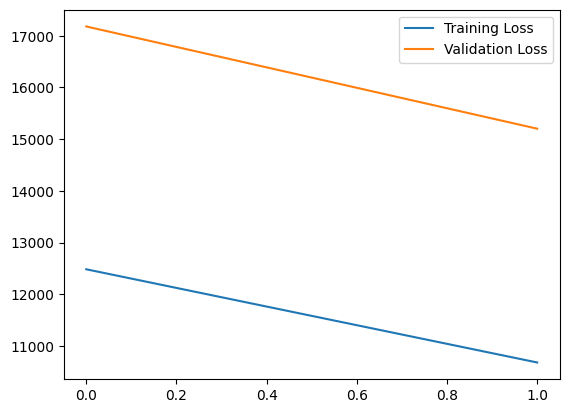

In [ ]:
autoencoder = AutoEncoder3D(scans.shape[1:])
history = autoencoder.train(scans, epochs=2, batch_size=8)

# Plot the training loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()
